In [6]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sympy as sm
import sympy.physics.mechanics as me

import robot
from integrate import integrate_eom
import interpolation


%config InlineBackend.figure_formats = ['svg']
me.functions.mechanics_printing(use_latex="mathjax", latex_mode="equation")

In [7]:
r = robot.SerialRobot()

physical_params = {
    r.g: 9.8,  # Gravity
    r.la: 1,  # The first link length.
    r.lb: 0.2,  # The second link length.
    r.ma: 1,  # The mass of the first link.
    r.mb: 5,  # The mass of the second link.
    r.Ia: 1,  # The moment of inertia of the first link.
    r.Ib: 5,  # The moment of inertia of the second link.
}

In [8]:
# In this example, ddth2, ddx are given,
# uth2 and ux can be calculated from them.
sol = sm.solve(
    r.eom.subs(physical_params),
    [r.ddth1, r.uth2, r.ux],
)

In [9]:
def ref_x(t):
    return 0


def ref_dx(t):
    return 0


def ref_ddx(t):
    return 0


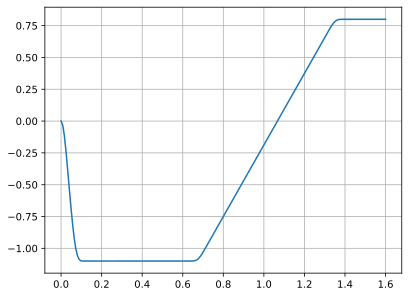

In [10]:

tf = 1.6
knots, ss, vels, accs, jerks = interpolation.path_jerk(tf, 45)

constraints = [
        ss[0] == 0, vels[0] == 0,
        ss[3] == -1.1, vels[3] == 0,
        ss[18] == -1.1, vels[18] == 0,
        ss[-7] == 0.8, vels[-7] == 0,
        ss[-1] == 0.8, vels[-1] == 0,
    ]

prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs))), constraints)
prob.solve()

def ref_th2(t):
    return interpolation.pos(t, knots, ss, vels, accs, jerks)


def ref_dth2(t):
    return interpolation.vel(t, knots, ss, vels, accs, jerks)


def ref_ddth2(t):
    return interpolation.acc(t, knots, ss, vels, accs, jerks)

int_ts = np.linspace(0, tf, 201)

fig, ax = plt.subplots()
ax.plot(int_ts, [interpolation.pos(t, knots, ss, vels, accs, jerks) for t in int_ts])
ax.grid()


In [11]:
def f(t, y):
    """
    Calculates dy/dt for given ddth2(t) and ddx(t).

    Parameters
    ----------
    t (float): Time.
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).

    Returns
    -------
    (ndarray): dy/dt = (dth1, dth2, dx, ddth1, ddth2, ddx).
    """
    return np.concatenate([
        y[3:],
        [float(me.msubs(
            sol[r.ddth1],
            {k: v for k, v in zip(r.state_vec, y)},
            {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)},
            ))],
        [ref_ddth2(t), ref_ddx(t)],
    ])

In [12]:
init_th1, init_dth1 = 0, 0

y0 = np.asarray([init_th1, ref_th2(knots[0]), ref_x(knots[0]),
                 init_dth1, ref_dth2(knots[0]), ref_dx(knots[0])])
xs, ys = integrate_eom(f, y0, knots, np.linspace(0, tf, 81))

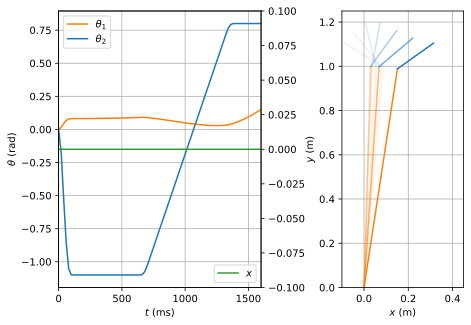

In [13]:
ms = 1e-3

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 5))


ax.plot(xs / ms, ys[0], label=r'$\theta_1$', c='C1')
ax.plot(xs / ms, ys[1], label=r'$\theta_2$', c='C0')

ax.legend()
ax.grid()
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\theta$ (rad)')

ax.set_xlim(0, tf / ms)

tax = ax.twinx()
tax.plot(xs / ms, ys[2], label=r'$x$', c='C2')
tax.set_ylim(-0.1, 0.1)

tax.legend(loc='lower right')


def draw_motions(ax):
    len_a = physical_params[r.la]
    len_b = physical_params[r.lb]
    
    alphas = np.exp((xs - xs[-1]) / (xs[-1] - xs[0]) * 5)

    for (th1, th2, x, *_), alpha in zip(ys.T[::-8], alphas[::-8]):
        # th1_val, th2_val, *_ = y

        # len_a, len_b = physical_params[la], physical_params[lb]
        p_x = [x * np.sin(th1), x * np.cos(th1)]
        p_a = [(len_a + x) * np.sin(th1),
            (len_a + x) * np.cos(th1)]
        p_b = [(len_a + x) * np.sin(th1) + len_b * np.sin(th1 + th2),
            (len_a + x) * np.cos(th1) + len_b * np.cos(th1 + th2)]

        ax.plot([0, p_x[0]], [0, p_x[1]], c='C2', alpha=alpha)
        ax.plot([p_x[0], p_a[0]], [p_x[1], p_a[1]], c='C1', alpha=alpha)
        ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], c='C0', alpha=alpha)
    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    
    ax.set_xlim(-0.1, 0.45)
    ax.set_ylim(0, 1.25)


draw_motions(ax2)

In [14]:
ys[0, -1], ys[3, -1]

(0.15158799543116566, 0.6643100071506682)